In [12]:
import numpy as np
from skimage import feature
import pickle
from sklearn.svm import SVC
import random

SEED=444
random.seed(SEED) # Use this to get repeateable randomisation

class features_class:
    def __init__(self,X,y):
        self.X = X
        self.y = y
def apply_features_filter(given_X):
    temp_X = np.delete(given_X,[8,26,52],1)
    return temp_X

# Load training feature files
dataset_base_path = "/scratch/data/latest_dataset/out"
with open (dataset_base_path +"/train_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-cmask-thick-6.pickle",'rb') as f:
    my_features_cmask = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_cmask.X), len(my_features_cmask.X[1]))
with open (dataset_base_path +"/train_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-pass.pickle",'rb') as f:
    my_features_pass = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_pass.X), len(my_features_pass.X[1]))
with open (dataset_base_path +"/train_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-comb-thick-6-k-0.2.pickle",'rb') as f:
    my_features_comb = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_comb.X), len(my_features_comb.X[1]))

# Load test feature files
with open (dataset_base_path +"/test_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-cmask-thick-6.pickle",'rb') as f:
    test_cmask = pickle.load(f)
    print "Test: Loaded %d images x %d features " %(len(test_cmask.X), len(test_cmask.X[1]))
with open (dataset_base_path +"/test_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-pass.pickle",'rb') as f:
    test_pass = pickle.load(f)
    print "Test: Loaded %d images x %d features " %(len(test_pass.X), len(test_pass.X[1]))
with open (dataset_base_path +"/test_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-comb-thick-6-k-0.2.pickle",'rb') as f:
    test_comb = pickle.load(f)
    print "Test: Loaded %d images x %d features " %(len(test_comb.X), len(test_comb.X[1]))
    

# Perform a simple check for the cmask
X = np.asarray(my_features_cmask.X).copy()
#X = np.concatenate((X,my_features_2.X),axis=0)
X = X+ np.asarray(my_features_pass.X).copy()*0.2

# filter features
X= apply_features_filter(X)
my_features_pass.X  = apply_features_filter(my_features_pass.X)
my_features_cmask.X = apply_features_filter(my_features_cmask.X)
my_features_comb.X = apply_features_filter(my_features_comb.X)
test_pass.X  = apply_features_filter(test_pass.X)
test_cmask.X = apply_features_filter(test_cmask.X)
test_comb.X = apply_features_filter(test_comb.X)

y = np.asarray(my_features_cmask.y).copy()
#y = np.concatenate((y,my_features_2.y),axis=0)
print "Pass    : ", len(my_features_pass.X), ' x ', len(my_features_pass.X[0])
print "Cmask   : ", len(my_features_cmask.X), ' x ', len(my_features_cmask.X[0])
print "Combined: ", len(X), ' x ', len(X[0])




Loaded 24000 images x 54 features 
Loaded 24000 images x 54 features 
Loaded 24000 images x 54 features 
Test: Loaded 6000 images x 54 features 
Test: Loaded 6000 images x 54 features 
Test: Loaded 6000 images x 54 features 
Pass    :  24000  x  51
Cmask   :  24000  x  51
Combined:  24000 24000  x  51


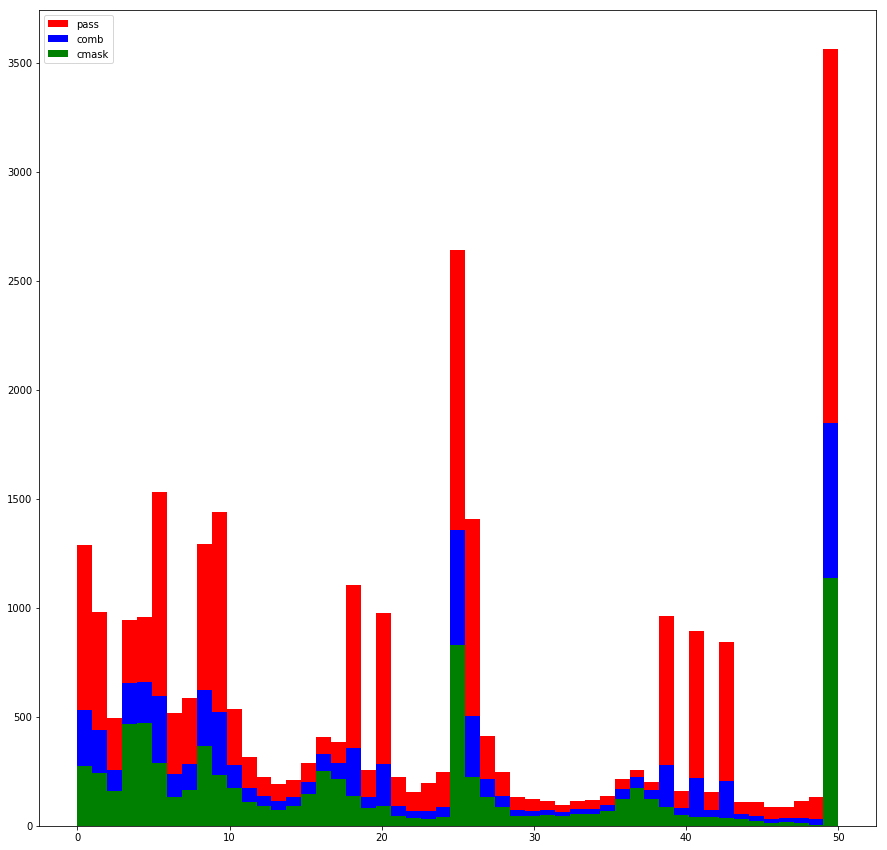

In [17]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15,15)
n_features=len(my_features_pass.X[0])
plt.hist(range(n_features), bins=n_features, weights=my_features_pass.X[0],color='r')
plt.hist(range(n_features), bins=n_features, weights=my_features_comb.X[0],color='b')
plt.hist(range(n_features), bins=n_features, weights=my_features_cmask.X[0],color='g')
plt.legend(['pass','comb','cmask'])
#plt.plot(my_features_cmask.X[0],'b')
plt.show()


In [16]:
# TODO if randomisation is required, we can do something like this ... otherwise skip this cell

do_randomize_training_set = False

if do_randomize_training_set:
    indices=np.asarray(range(len(X)))
    random.shuffle(indices)

    print ' Shuffling using indices: ', indices
    my_features_cmask.X = my_features_cmask.X[indices]
    my_features_cmask.y = my_features_cmask.y[indices]
    
    my_features_pass.X = my_features_pass.X[indices]
    my_features_pass.y = my_features_pass.y[indices]
    
    my_features_comb.X = my_features_comb.X[indices]
    my_features_comb.y = my_features_comb.y[indices]
    print my_features_cmask.y
else:
    print 'Skipping Randomisation of training sets'

Skipping Randomisation of training sets


In [14]:
print "Fitting cmask method"
my_C = 30
my_gamma = 1e-5

my_classifier_cmask = SVC(kernel = 'rbf',
                         C      = my_C ,
                         gamma  = my_gamma)
model_cmask = my_classifier_cmask.fit(my_features_cmask.X, my_features_cmask.y)

print "Fitting pass method"
my_classifier_pass = SVC(kernel = 'rbf',
                         C      = my_C ,
                         gamma  = my_gamma)
model_pass = my_classifier_pass.fit(my_features_pass.X, my_features_pass.y)

print "Fitting combined cmask method"
my_classifier_comb = SVC(kernel = 'rbf',
                         C      = my_C ,
                         gamma  = my_gamma)
model_comb = my_classifier_comb.fit(X,y)
print 'Training Done'

Fitting cmask method
Fitting pass method
Fitting combined cmask method
Training Done


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

features = test_cmask.X
labels   = test_cmask.y
predictions = model_cmask.predict(features)

current_score = accuracy_score(labels, predictions)
print '======================='
print('Accuracy Score cmask= %f' %(current_score) )
print(confusion_matrix(labels, predictions))
print(classification_report(labels, predictions))

features = test_pass.X
labels   = test_pass.y
predictions = model_pass.predict(features)

current_score = accuracy_score(labels, predictions)
print '======================='
print('Accuracy Score pass= %f' %(current_score) )
print(confusion_matrix(labels, predictions))
print(classification_report(labels, predictions))

features = test_comb.X
labels   = test_comb.y
predictions = model_comb.predict(features)

current_score = accuracy_score(labels, predictions)
print '======================='
print('Accuracy Score combined= %f' %(current_score) )
print(confusion_matrix(labels, predictions))
print(classification_report(labels, predictions))

print 'Done'

Accuracy Score cmask= 0.892667
[[1474   10    3   13]
 [   3 1202   15  280]
 [   1    9 1479   11]
 [  58  207   34 1201]]
              precision    recall  f1-score   support

  background       0.96      0.98      0.97      1500
         can       0.84      0.80      0.82      1500
        corn       0.97      0.99      0.98      1500
      radish       0.80      0.80      0.80      1500

   micro avg       0.89      0.89      0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000

Accuracy Score pass= 0.869833
[[1467    9    1   23]
 [   0 1111   26  363]
 [   3   78 1351   68]
 [  54  143   13 1290]]
              precision    recall  f1-score   support

  background       0.96      0.98      0.97      1500
         can       0.83      0.74      0.78      1500
        corn       0.97      0.90      0.93      1500
      radish       0.74      0.86      0.80      1500

   micro avg       0.87      0.87      0.87   